<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/CNN-TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Computer Vision Using Tensorflow

# Setup

This project requires Python 3.7 or above:

In [71]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [72]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [73]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

let's define the default font sizes to make the figures prettier:

In [74]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

This can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [75]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Convolutional Layers
## Implementing Convolutional Layers With Keras

Let's load two sample images, rescale their pixel values to 0-1, and center crop them to small 70×120 images:

In [76]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [77]:
images.shape

TensorShape([2, 70, 120, 3])

In [78]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [79]:
fmaps.shape

TensorShape([2, 64, 114, 32])

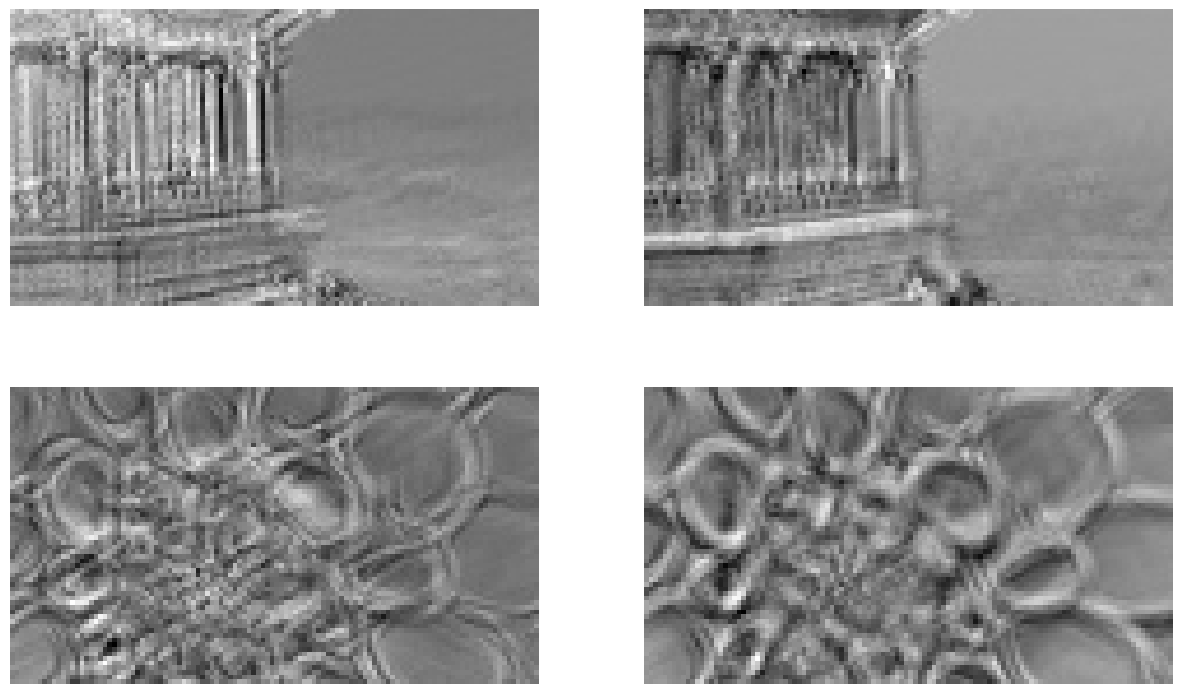

In [80]:
# extra code – displays the two output feature maps for each image

plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

As you can see, randomly generated filters typically act like edge detectors, which is great since that's a useful tool in image processing, and that's the type of filters that a convolutional layer typically starts with. Then, during training, it gradually learns improved filters to recognize useful patterns for the task.

Now let's use zero-padding:

In [81]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [82]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [83]:
# extra code – shows that the output shape when we set strides=2
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [84]:
# extra code – this utility function can be useful to compute the size of the
#              feature maps output by a convolutional layer. It also returns
#              the number of ignored rows or columns if padding="valid", or the
#              number of zero-padded rows or columns if padding="same"."""

import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

Let's now look at the weights:

In [85]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [86]:
biases.shape

(32,)

In [87]:
# extra code – shows how to use the tf.nn.conv2d() operation

tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

Let's manually create two filters full of zeros, except for a vertical line of 1s in the first filter, and a horizontal one in the second filter. The two output feature maps highlight vertical lines and horizontal lines, respectively. In practice you will probably never need to create filters manually, since the convolutional layers will learn them automatically.

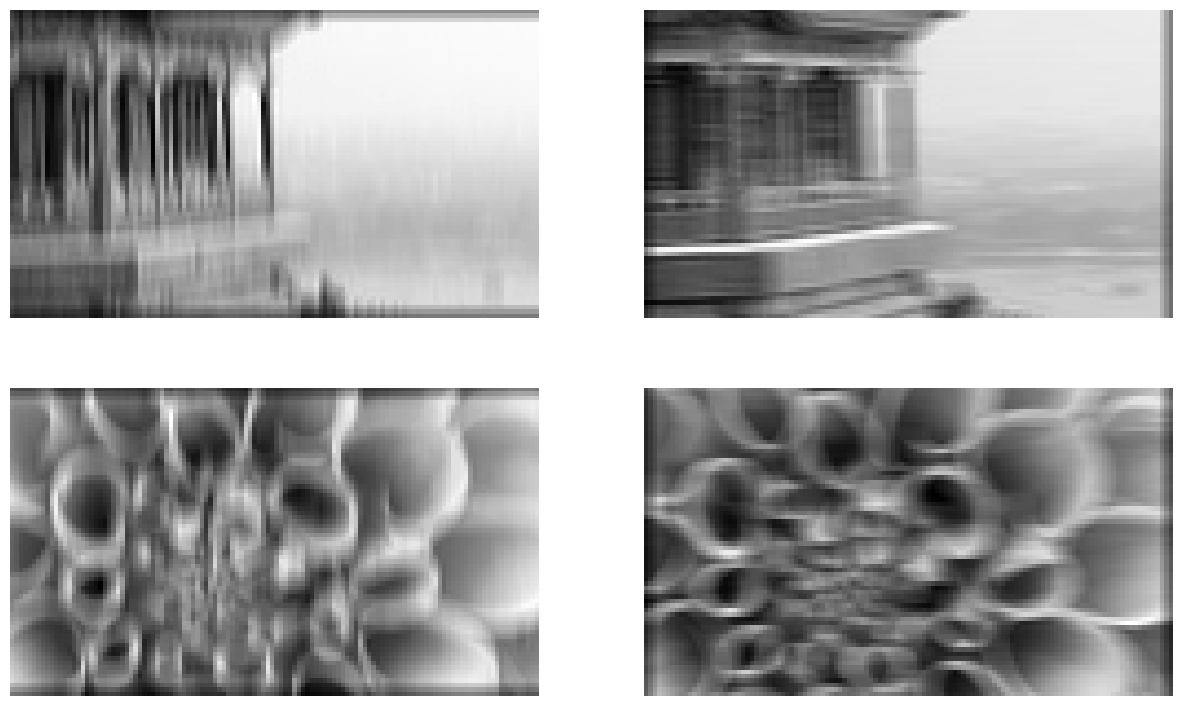

In [88]:
# extra code – shows how to manually create two filters to get images similar
#              to those in Figure 14–5.

plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

Notice the dark lines at the top and bottom of the two images on the left, and on the left and right of the two images on the right? Can you guess what these are? Why were they not present in the previous figure?

You guessed it! These are artifacts due to the fact that we used zero padding in this case, while we did not use zero padding to create the feature maps in the previous figure. Because of zero padding, the two feature maps based on the vertical line filter (i.e., the two left images) could not fully activate near the top and bottom of the images. Similarly, the two feature maps based on the horizontal line filter (i.e., the two right images) could not fully activate near the left and right of the images.

# Pooling Layers
## Implementing Pooling Layers With Keras

**Max pooling**

In [89]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [90]:
output = max_pool(images)

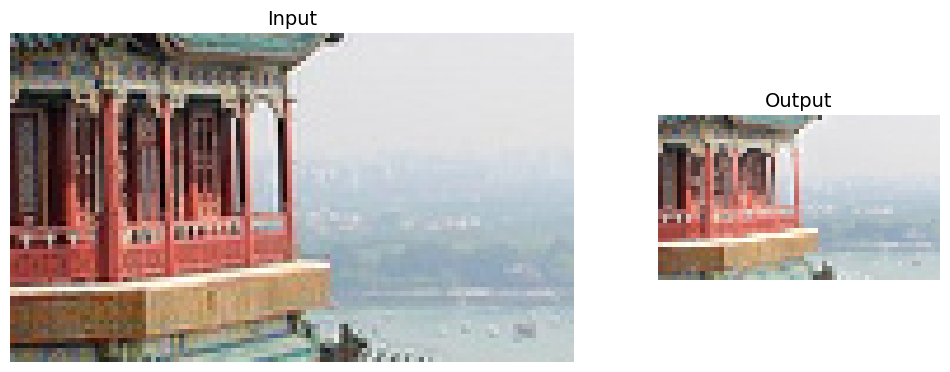

In [91]:
# extra code – this cells shows what max pooling with stride = 2 looks like

import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

**Global Average Pooling**

In [93]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

The following layer is equivalent:

In [94]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [95]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.643388  , 0.59718215, 0.5825038 ],
       [0.7630747 , 0.26010972, 0.10848834]], dtype=float32)>

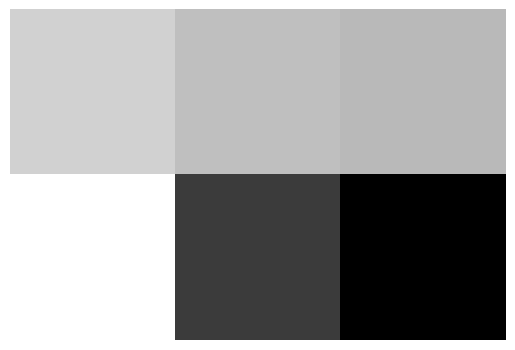

In [97]:
output = global_avg_pool(images)

plt.imshow(output, cmap="gray")
plt.axis("off")

plt.show()

# CNN Architectures

**Tackling Fashion MNIST With a CNN**

In [29]:
# extra code – loads the mnist dataset, add the channels axis to the inputs,
#              scales the values to the 0-1 range, and splits the dataset
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


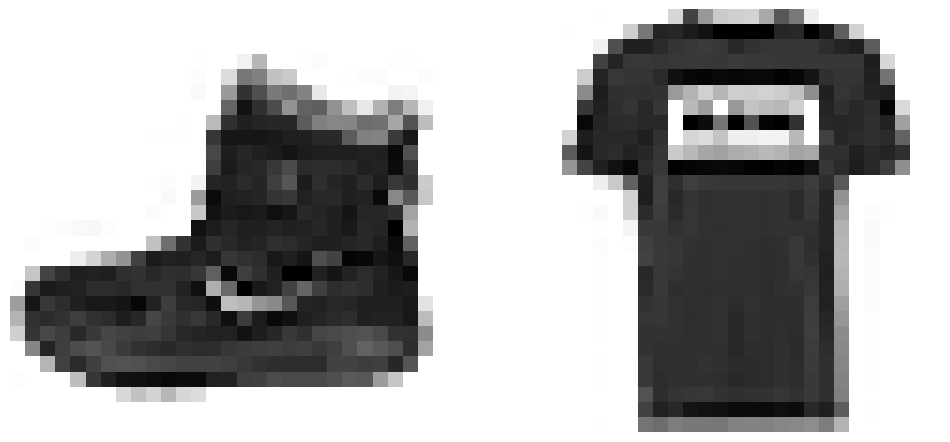

In [30]:
plt.figure(figsize=(12, 8))
for image_idx in (0, 1):
    plt.subplot(1, 2, image_idx + 1)
    plt.imshow(X_train_full[image_idx], cmap="binary")
    plt.axis("off")

plt.show()

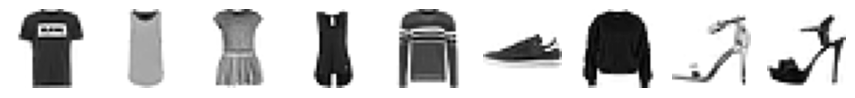

In [31]:
plt.figure(figsize=(12, 8))
for image_idx in range(1,10):
    plt.subplot(1, 10, image_idx + 1)
    plt.imshow(X_train_full[image_idx], cmap="binary")
    plt.axis("off")

plt.show()

In [32]:
np.unique(y_train_full)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

|Label	| Description|
|---|:---:|
0	|T-shirt/top
1	|Trouser
2	|Pullover
3	|Dress
4	|Coat
5	|Sandal
6	|Shirt
7	|Sneaker
8	|Bag
9	|Ankle boot

In [33]:
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [34]:
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [35]:
from functools import partial

tf.random.set_seed(42)  # extra code – ensures reproducibility
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.6152 - loss: 1.0934 - val_accuracy: 0.8700 - val_loss: 0.3563
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8487 - loss: 0.4453 - val_accuracy: 0.8838 - val_loss: 0.3127
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8764 - loss: 0.3693 - val_accuracy: 0.8958 - val_loss: 0.2762
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8915 - loss: 0.3201 - val_accuracy: 0.8984 - val_loss: 0.2713
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9028 - loss: 0.2905 - val_accuracy: 0.9050 - val_loss: 0.2739
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9102 - loss: 0.2652 - val_accuracy: 0.9074 - val_loss: 0.2691
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9153 - loss: 0.2524 - val_accuracy: 0.9078 - val_loss: 0.2871
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9184 - loss: 0

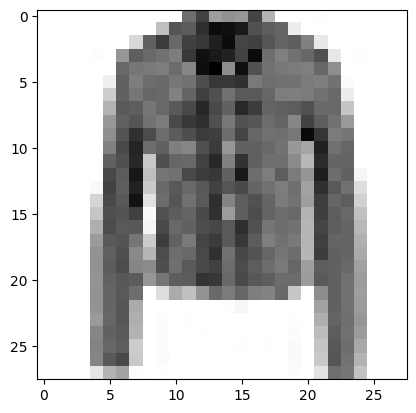

In [37]:
plt.imshow(X_test[10], cmap="binary")

In [38]:
X_new = X_test[10]  # pretend we have new images
X_new = np.expand_dims(X_new, axis=0) # Add a batch dimension
y_pred = model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step


In [39]:
for idx, prob in enumerate(y_pred[0]):
    print(f"{idx:2}: {prob:.2%}")

 0: 0.00%
 1: 0.00%
 2: 0.00%
 3: 0.00%
 4: 99.99%
 5: 0.00%
 6: 0.01%
 7: 0.00%
 8: 0.00%
 9: 0.00%


In [40]:
for idx, prob in enumerate(y_pred[0]):
    print(f"{labels[idx]:12s}: {prob:.2%}")

T-shirt/top : 0.00%
Trouser     : 0.00%
Pullover    : 0.00%
Dress       : 0.00%
Coat        : 99.99%
Sandal      : 0.00%
Shirt       : 0.01%
Sneaker     : 0.00%
Bag         : 0.00%
Ankle boot  : 0.00%


In [46]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(2, 1000)

## High Accuracy CNN for MNIST
_Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST._

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [98]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [70]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Conv2D(64, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8871 - loss: 0.3721 - val_accuracy: 0.9856 - val_loss: 0.0518
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9724 - loss: 0.0910 - val_accuracy: 0.9900 - val_loss: 0.0400
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9802 - loss: 0.0662 - val_accuracy: 0.9910 - val_loss: 0.0381
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9842 - loss: 0.0527 - val_accuracy: 0.9904 - val_loss: 0.0384
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9861 - loss: 0.0440 - val_accuracy: 0.9916 - val_loss: 0.0327
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9878 - loss: 0.0361 - val_accuracy: 0.9922 - val_loss: 0.0384
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9899 - loss: 0.0329 - val_accuracy: 0.9908 - val_loss: 0.0446
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9906 - loss: 0.02

[0.03136149421334267, 0.9921000003814697]